In [1]:
# The Three Building Blocks

# 1. Linear Layer -> (like a calculator, takes 30 numbers, outputs 100 numbers)
# 2. BatchNorm Layer -> (the balancer, as numbers pass through many layers, 
#    numbers can become too big or too small, BatchNorm keeps them reasonable)
# 3. TanH Layer -> Takes any number and squishes it between 1 and -1

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

words = open("../data/names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
# Build character vocab
chars = sorted(list(set(''.join(words))))  # all unique characters
stoi = {s:i+1 for i,s in enumerate(chars)}  # string to index
stoi['.'] = 0  # special token for start/end
itos = {i:s for s,i in stoi.items()}  # index to string
vocab_size = len(itos)

In [5]:
# Build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [16]:
# Create Linear Layer Class

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        # Implement Forward Pass
        self.out = x @ self.weight
        if self.bias is not None:
            self.out = self.out + self.bias
        return self.out

    def parameters(self):
        if self.bias is not None:
            return [self.weight, self.bias]
        else:
            return [self.weight]
            

In [17]:
g = torch.Generator().manual_seed(2147483647)
layer = Linear(10, 5)
x = torch.randn(3, 10)  # 3 examples, 10 features
out = layer(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")  # should be (3, 5)
print(f"Number of parameters: {sum(p.nelement() for p in layer.parameters())}")

Input shape: torch.Size([3, 10])
Output shape: torch.Size([3, 5])
Number of parameters: 55


In [57]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Parameters (trainable)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # Buffers (not trainable)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # Calculate forward pass
        if self.training:
            # Use batch statistics
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=False)
        else:
            # Use running statistics
            xmean = self.running_mean
            xvar = self.running_var
        
        # Normalize
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        
        # Scale and shift
        self.out = self.gamma * xhat + self.beta
        
        # Update running statistics
        if self.training:
            with torch.no_grad():
                # IMPORTANT: Remove the extra dimension from xmean and xvar
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean.squeeze(0)
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar.squeeze(0)
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [58]:
# Test BatchNorm1d
bn = BatchNorm1d(5)
x = torch.randn(10, 5) * 10 + 50  # mean≈50, std≈10

print("Before BatchNorm:")
print(f"Mean: {x.mean(0)}")
print(f"Std: {x.std(0)}")

out = bn(x)

print("\nAfter BatchNorm:")
print(f"Mean: {out.mean(0)}")  # should be close to 0
print(f"Std: {out.std(0)}")    # should be close to 1

print(f"\nNumber of parameters: {sum(p.nelement() for p in bn.parameters())}")  # should be 10 (5 gamma + 5 beta)

Before BatchNorm:
Mean: tensor([49.0714, 49.1199, 44.7723, 51.2458, 48.2709])
Std: tensor([12.1673, 10.4179, 11.7738, 11.9333, 14.3869])

After BatchNorm:
Mean: tensor([-4.8280e-07,  1.1921e-08, -2.2650e-07, -1.6689e-07,  1.2517e-07])
Std: tensor([1.0541, 1.0541, 1.0541, 1.0541, 1.0541])

Number of parameters: 10


In [59]:
# Create the TanH Layer

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


In [60]:
# Test Tanh
tanh = Tanh()
x = torch.tensor([-5.0, -1.0, 0.0, 1.0, 5.0])
out = tanh(x)
print(f"Input: {x}")
print(f"Output: {out}")  # should be close to [-1, -0.76, 0, 0.76, 1]
print(f"Parameters: {len(tanh.parameters())}")  # should be 0

Input: tensor([-5., -1.,  0.,  1.,  5.])
Output: tensor([-0.9999, -0.7616,  0.0000,  0.7616,  0.9999])
Parameters: 0


In [61]:
# Setup Network Architecture
n_embd = 10 # embedding dimension
n_hidden = 100 #hidden layer size
vocab_size = 27
block_size = 3 # context length

g = torch.Generator().manual_seed(2147483647)

In [62]:
# Create Character embedding table
C = torch.randn((vocab_size, n_embd), generator=g)
C.shape

torch.Size([27, 10])

In [63]:
# Build network layers
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1

In [64]:
# Collect all parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True

In [65]:
# Testing forward pass
ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)  # sample 32 examples
Xb, Yb = Xtr[ix], Ytr[ix]

# Forward pass
emb = C[Xb]  # (32, 3, 10) - 32 examples, 3 chars, 10 dimensions each
print(f"Embedding shape: {emb.shape}")

x = emb.view(emb.shape[0], -1)  # (32, 30) - flatten
print(f"Flattened shape: {x.shape}")

# Pass through all layers
for layer in layers:
    x = layer(x)
    print(f"{layer.__class__.__name__:15s} -> {x.shape}")

# Calculate loss
loss = F.cross_entropy(x, Yb)
print(f"\nInitial loss: {loss.item():.4f}")

Embedding shape: torch.Size([32, 3, 10])
Flattened shape: torch.Size([32, 30])
Linear          -> torch.Size([32, 100])
BatchNorm1d     -> torch.Size([32, 100])
Tanh            -> torch.Size([32, 100])
Linear          -> torch.Size([32, 100])
BatchNorm1d     -> torch.Size([32, 100])
Tanh            -> torch.Size([32, 100])
Linear          -> torch.Size([32, 100])
BatchNorm1d     -> torch.Size([32, 100])
Tanh            -> torch.Size([32, 100])
Linear          -> torch.Size([32, 100])
BatchNorm1d     -> torch.Size([32, 100])
Tanh            -> torch.Size([32, 100])
Linear          -> torch.Size([32, 100])
BatchNorm1d     -> torch.Size([32, 100])
Tanh            -> torch.Size([32, 100])
Linear          -> torch.Size([32, 27])
BatchNorm1d     -> torch.Size([32, 27])

Initial loss: 3.3173


In [66]:
# Training hyperparameters
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # 1. Simple Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # 2. Forward Pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate embeddings
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # 3. Backward Pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    # 4. Update parameters
    lr = 0.1 if i < 150000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad

    # 5. Track statistics
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    

      0/ 200000: 3.2661
  10000/ 200000: 2.1920
  20000/ 200000: 2.0275
  30000/ 200000: 1.8103
  40000/ 200000: 1.8109
  50000/ 200000: 2.1085
  60000/ 200000: 2.2533
  70000/ 200000: 1.7763
  80000/ 200000: 2.4959
  90000/ 200000: 2.0763
 100000/ 200000: 1.9363
 110000/ 200000: 2.1222
 120000/ 200000: 1.8815
 130000/ 200000: 2.1801
 140000/ 200000: 2.4995
 150000/ 200000: 1.9778
 160000/ 200000: 2.4557
 170000/ 200000: 1.8502
 180000/ 200000: 1.9687
 190000/ 200000: 1.9463


layer 2 (      Tanh): mean +0.01, std 0.73, saturated: 18.34%
layer 5 (      Tanh): mean -0.00, std 0.76, saturated: 20.81%
layer 8 (      Tanh): mean +0.02, std 0.78, saturated: 21.75%
layer 11 (      Tanh): mean -0.01, std 0.79, saturated: 22.91%
layer 14 (      Tanh): mean -0.02, std 0.80, saturated: 23.72%


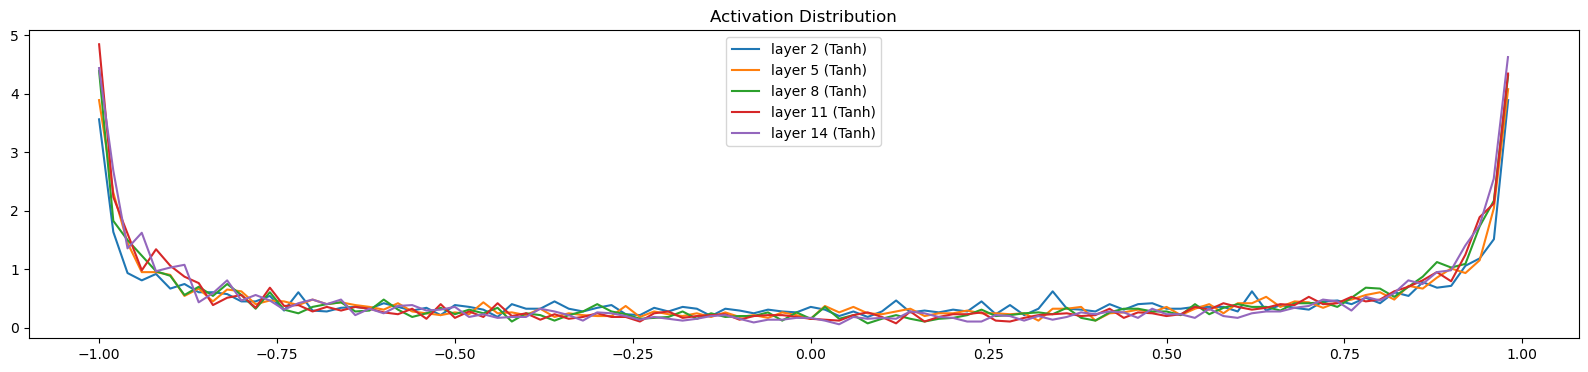

In [67]:
# Check activation health
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % 
              (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distribution')
plt.show()

layer 2 (      Tanh): mean +0.000000, std 3.791002e-03
layer 5 (      Tanh): mean -0.000000, std 3.682392e-03
layer 8 (      Tanh): mean -0.000000, std 3.552245e-03
layer 11 (      Tanh): mean +0.000000, std 3.000305e-03
layer 14 (      Tanh): mean -0.000000, std 3.059091e-03


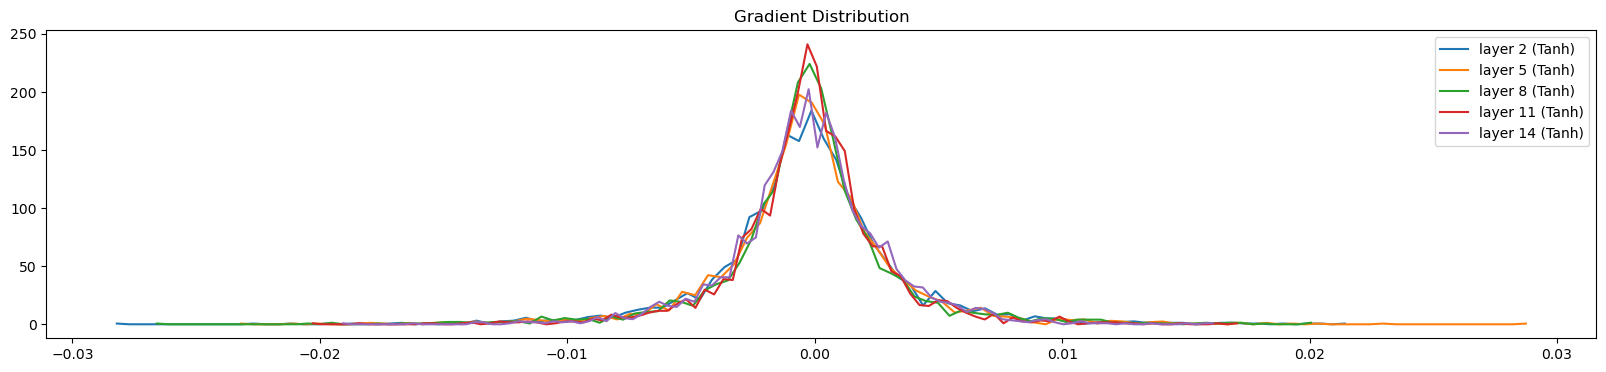

In [68]:
# Check gradient health
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % 
              (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient Distribution')
plt.show()

weight   (27, 10) | mean +0.000000 | std 1.779204e-02 | grad:data ratio 1.558102e-02
weight  (30, 100) | mean -0.000084 | std 9.940102e-03 | grad:data ratio 2.474044e-02
weight (100, 100) | mean -0.000066 | std 5.983692e-03 | grad:data ratio 2.467591e-02
weight (100, 100) | mean +0.000027 | std 5.616360e-03 | grad:data ratio 2.330756e-02
weight (100, 100) | mean -0.000044 | std 5.060084e-03 | grad:data ratio 2.205468e-02
weight (100, 100) | mean +0.000054 | std 4.382209e-03 | grad:data ratio 2.047176e-02
weight  (100, 27) | mean -0.000060 | std 6.878910e-03 | grad:data ratio 1.952106e-02


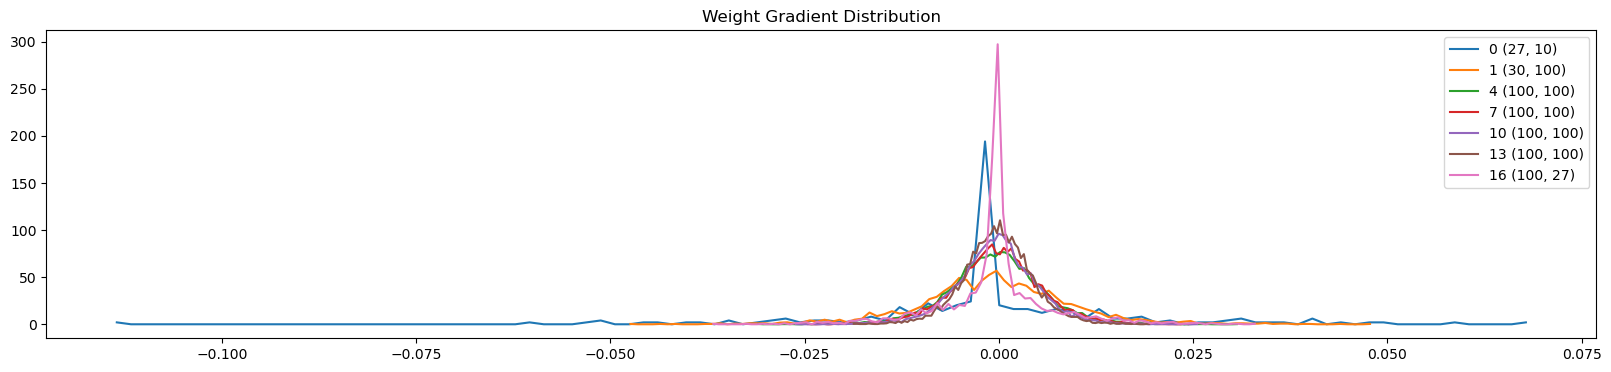

In [69]:
# Check weight gradient distribution
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % 
              (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weight Gradient Distribution')
plt.show()

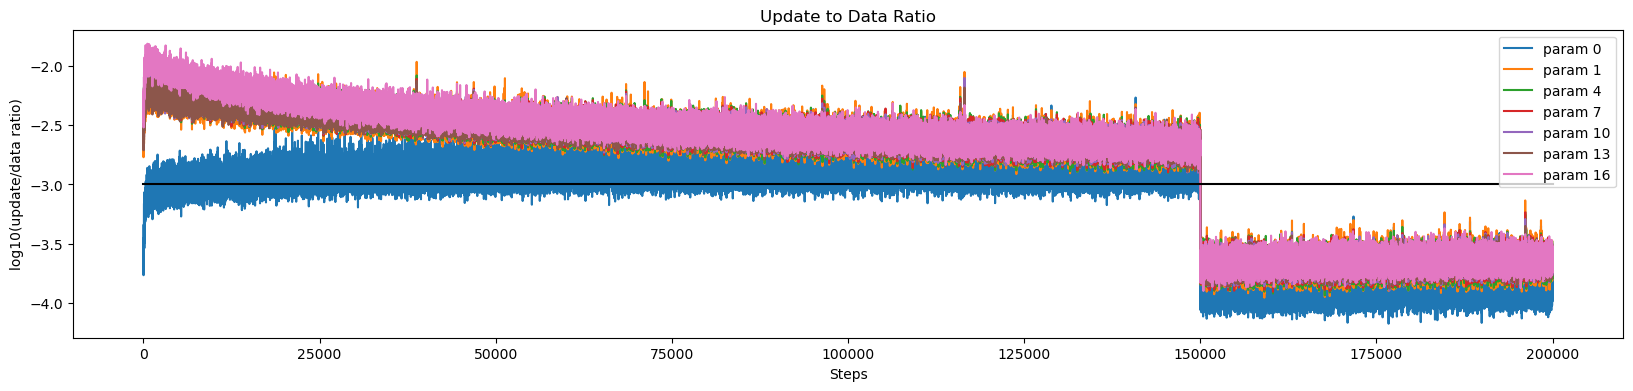

In [70]:
# Plot update-to-data ratios
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')  # target line at -3 (10^-3 = 0.001)
plt.legend(legends)
plt.title('Update to Data Ratio')
plt.xlabel('Steps')
plt.ylabel('log10(update/data ratio)')
plt.show()

In [71]:
# Sample from the model
for layer in layers:
    layer.training = False

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size  # initialize with all '...'
    
    while True:
        # Forward pass
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        x = emb.view(emb.shape[0], -1)  # concatenate
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        # Shift the context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        
        # If we sample '.', break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmahzate.
harlin.
mili.
tatyannah.
skyla.
hutnalee.
rhy.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
polet.
dian.
shon.
walliani.
wazell.
dearyxi.
jace.
pius.


In [72]:
# ========== EVAL MODE ==========
for layer in layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

# ========== BATCH SAMPLING (safer) ==========
@torch.no_grad()
def sample_names(num_samples=20):
    """Sample multiple names at once (batch inference)"""
    g = torch.Generator().manual_seed(2147483647 + 10)
    
    for _ in range(num_samples):
        out = []
        context = [0] * block_size
        
        while True:
            # Create batch of size 32 (all same context)
            contexts = torch.tensor([context] * 32)
            
            # Forward pass
            emb = C[contexts]
            x = emb.view(emb.shape[0], -1)
            for layer in layers:
                x = layer(x)
            
            # Take only first prediction
            logits = x[0:1]
            probs = F.softmax(logits, dim=1)
            
            # Sample
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            
            context = context[1:] + [ix]
            out.append(ix)
            
            if ix == 0:
                break
        
        print(''.join(itos[i] for i in out))

sample_names(20)

carmahzate.
harlin.
mili.
tatyannah.
skyla.
hutnalee.
rhy.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
polet.
dian.
shon.
walliani.
wazell.
dearyxi.
jace.
pius.


In [73]:
print("Checking BatchNorm running statistics:")
for i, layer in enumerate(layers):
    if isinstance(layer, BatchNorm1d):
        print(f"\nLayer {i}:")
        print(f"  running_mean: {layer.running_mean[:5]}")
        print(f"  running_var: {layer.running_var[:5]}")
        print(f"  Has NaN? {torch.isnan(layer.running_mean).any() or torch.isnan(layer.running_var).any()}")

Checking BatchNorm running statistics:

Layer 1:
  running_mean: tensor([-0.3147, -1.1889, -0.0051,  0.4227, -0.5717])
  running_var: tensor([3.5724, 4.3789, 3.9700, 4.6443, 3.0448])
  Has NaN? False

Layer 4:
  running_mean: tensor([-0.6782, -0.3121,  0.1968,  0.0425, -0.2781])
  running_var: tensor([5.4839, 5.4879, 4.7909, 4.5590, 5.5866])
  Has NaN? False

Layer 7:
  running_mean: tensor([-0.2725,  0.2705,  0.1675,  0.0363, -0.1721])
  running_var: tensor([4.9997, 5.2834, 5.3384, 5.2334, 5.5242])
  Has NaN? False

Layer 10:
  running_mean: tensor([-0.0188, -0.0373,  0.5894, -0.3809, -0.2865])
  running_var: tensor([4.7082, 5.2843, 4.2287, 4.5301, 5.6258])
  Has NaN? False

Layer 13:
  running_mean: tensor([-0.2686,  0.0999,  0.2157, -0.0103, -0.2790])
  running_var: tensor([3.6460, 3.3955, 4.4010, 4.9951, 5.4300])
  Has NaN? False

Layer 16:
  running_mean: tensor([-1.0759, -1.7275, -0.5949,  1.1919,  0.5141])
  running_var: tensor([76.9391, 38.8350, 12.4067, 13.9572, 23.2966])
  Ha